# Código para identificar eventos em portões

**Disciplina**: Visão Computacional

**Alunos**: Arthur Rodrigues Fernandes, Vinicius Wolosky Muchulski, Sandy Hoffmann


Nesse notebook iremos abordar técnicas de computação clássica para detectar eventos em portões residenciais, onde há um fluxo intenso de entrada de carros, motos e pessoas. Os eventos de abertura, movimento e fechamento do portão devem ser notados e analisados, sendo possível determinar se o portão foi deixado aberto, ou se uma pessoa adentrou o prédio apartir do mesmo.

Para isso, serão utilizados métodos no campo da visão e espaço. As filmagens são disponibilizadas por um prédio de Ararangua, possuindo câmeras de posição fixa em diferentes localidades. O acesso a essas filmagens é possível por meio de api disponíbilizada pela própria marca da câmera.

O notebook analizará duas câmeras (Figuras 1 e 2):

- Uma que é voltada para a garagem, onde saem os automóveis.
- Outra que é voltada a porta de acesso ao edifício, onde entram os moradores, e é feito as entregas por interfone.

<div style="display: flex; justify-content: space-around;">
    <div style="text-align: center;">
        <img src="./imagens/camera1.png" width="90%">
        <p><em>Figura 1: Imagem da câmera de entrada para o portão.</em></p>
    </div>
    <div style="text-align: center;">
        <img src="./imagens/camera2.png" width="90%">
        <p><em>Figura 2: Imagem de entregador esperando na portaria.</em></p>
    </div>
</div>


---

### Bibliotecas utilizadas:

Para esse notebook, utilizamos a biblioteca opencv (versão 4.11.0.86) e matplotlib (para mostrar as imagens no processo).

In [162]:
! pip install opencv-python
! pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [163]:
import cv2 as cv
from matplotlib import pyplot as plt

---

### ***Câmera 1*** - Detecção automóveis e pessoas no portão

Carregando o vídeo que será utilizado:

In [164]:
video = cv.VideoCapture("./videos/Camera1-CarroSaindo2.mp4")
if not video.isOpened():
    print("Error opening video file")

In [165]:
def reset_video_to_start(video):
    video.set(cv.CAP_PROP_POS_FRAMES, 0)

Mostrando vídeo utilizado:

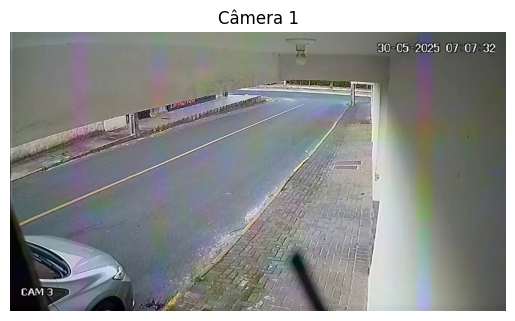

In [166]:
ret, frame = video.read()
if ret:
    plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Câmera 1')
    plt.show()
else:
    print("Não foi possível ler o frame do vídeo.")

Para evitarmos cenários que não interferem na avaliação de movimento do portão, para o processamento, cortamos a filmagem de acordo com a ***ROI - Região de Interesse***. Como as câmeras possuem o angulamento estático (não se movem), esse processo é feito dando coordenadas fixas.

In [167]:
roi_x, roi_y, roi_w, roi_h = 820, 150, 150, 456

Utilizaremos a técnica de subtração de fundos para detectar movimentos entre os frames. Ter como parâmetro apenas uma imagem como consideração de fundo pode trazer diversos problemas consigo, pois o vídeo é constantemente alterado, e pode aparecer sombras, variações de iluminação, e entre outros problemas. Por isso, foi pensado em utilizar o método do opencv "createBackgroundSubtractorMOG2", pois este utiliza de um algoritmo adaptativo para a subtração de fundo utilizando probabilidade de densidade gaussiana [1](#referencias). 

Esse modelo aprende do fundo, processando multiplos frames, através do atributo "history" - que funciona como a memória do algoritmo, ele guarda os frames anteriores para considerar a modelagem do fundo. O parametro "varThreshold" controla a sensibilidade do algoritmo a mudanças de pixeis, então é proporcional a sensibilidade a mudanças, com valores baixos detectando pequenas variações e valores altos apenas considerando variações mais significantes. Na nossa aplicação optamos para que o algoritmo ignore as sombras, utilizando a flag "detectShadows" = false.

In [168]:
bg_subtractor = cv.createBackgroundSubtractorMOG2(history=100, varThreshold=50, detectShadows=False)

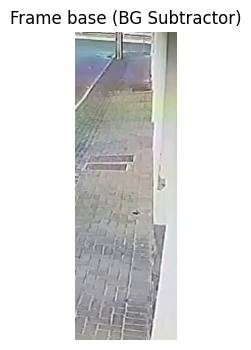

In [169]:
if ret:
    bg_subtractor.apply(frame[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w])
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(cv.cvtColor(bg_subtractor.getBackgroundImage(), cv.COLOR_BGR2RGB))
    plt.title('Frame base (BG Subtractor)')
    plt.axis('off')
    plt.show()
else:
    print("Não foi possível ler o frame do vídeo.")

Para controlar os estados do portão usaremos uma flag global, que determina se o portão está aberto, fechado ou "deixado aberto". Utilizaremos "thresholds" para diferenciar durante a subtração de fundo se o que estamos vendo são movimentos significantes, ou apenas ruídos.

In [170]:
fps = video.get(cv.CAP_PROP_FPS)

gate_state = "closed"  
frame_count = 0
movement_threshold = 1000  
stable_frames_threshold = 30  # Número de frames estáveis para considerar a porta aberta

qtd_frames_em_movimento = 0
qtd_segundos_para_abrir_fechar = 15
qtd_frames_para_abrir_fechar = qtd_segundos_para_abrir_fechar * fps


Para pré-processar o frame, foi necessário uma combinação de operações no domínio do valor, pois a imagem vinda da camera havia ruidos, como por exemplo, as faixas arco-iris (reflexos da lente), vistas na imagem da câmera 1. Utilizamos a função de blur afim de suavizar a imagem e após isso, a função de equalizar histograma, para melhorar o contraste da imagem.

![camera1.png](./imagens/camera1.png)

In [171]:
def retirar_ruidos_frame(frame):
    frame = cv.medianBlur(frame, 3)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)  
    frame = cv.equalizeHist(frame)  
    frame = cv.cvtColor(frame, cv.COLOR_GRAY2BGR)  
    return frame

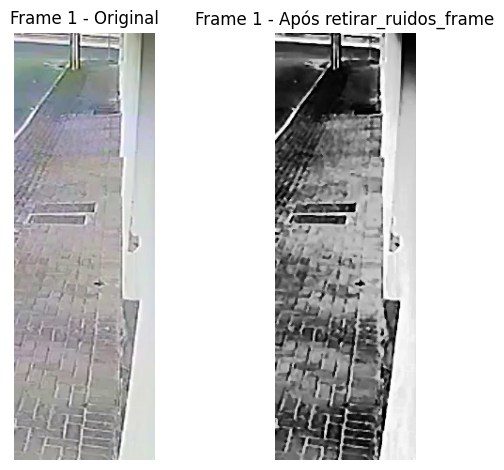

In [172]:
ret, frame = video.read()
if ret:
    # Frame original (ROI)
    plt.subplot(1, 2, 1)
    plt.imshow(cv.cvtColor(frame[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w], cv.COLOR_BGR2RGB))
    plt.title('Frame 1 - Original')
    plt.axis('off')

    # Frame após retirar_ruidos_frame
    roi1_sem_ruido = retirar_ruidos_frame(frame[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w])
    plt.subplot(1, 2, 2)
    plt.imshow(cv.cvtColor(roi1_sem_ruido, cv.COLOR_BGR2RGB))
    plt.title('Frame 1 - Após retirar_ruidos_frame')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Não foi possível ler o frame do vídeo.")


Para computar a mascara de movimento, iremos fazer a subtração do fundo pelo frame atual. Para remover o ruído da substração, usamos a função "morphologyEx", que é uma função de "Opening" (erosão -> dilatação). O Kernel é definido pela função "getStructuringElement", e é utilizado para suavizar o contorno das bordas do portão. O exemplo da nossa função "retorna_mascara", se comparada a uma subtração de diferença mais simples pode ser vista nas próximas figuras.

In [173]:
for i in range(87):  # Processar os primeiros  frames
    ret, frame = video.read()
    if not ret:
        break

    roi_treinando = frame[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]
    fg_mask = bg_subtractor.apply(roi_treinando)

In [174]:
def retorna_mascara(roi, bg_subtractor):
    fgmask = bg_subtractor.apply(roi)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    fgmask = cv.morphologyEx(fgmask, cv.MORPH_OPEN, kernel)
    return fgmask

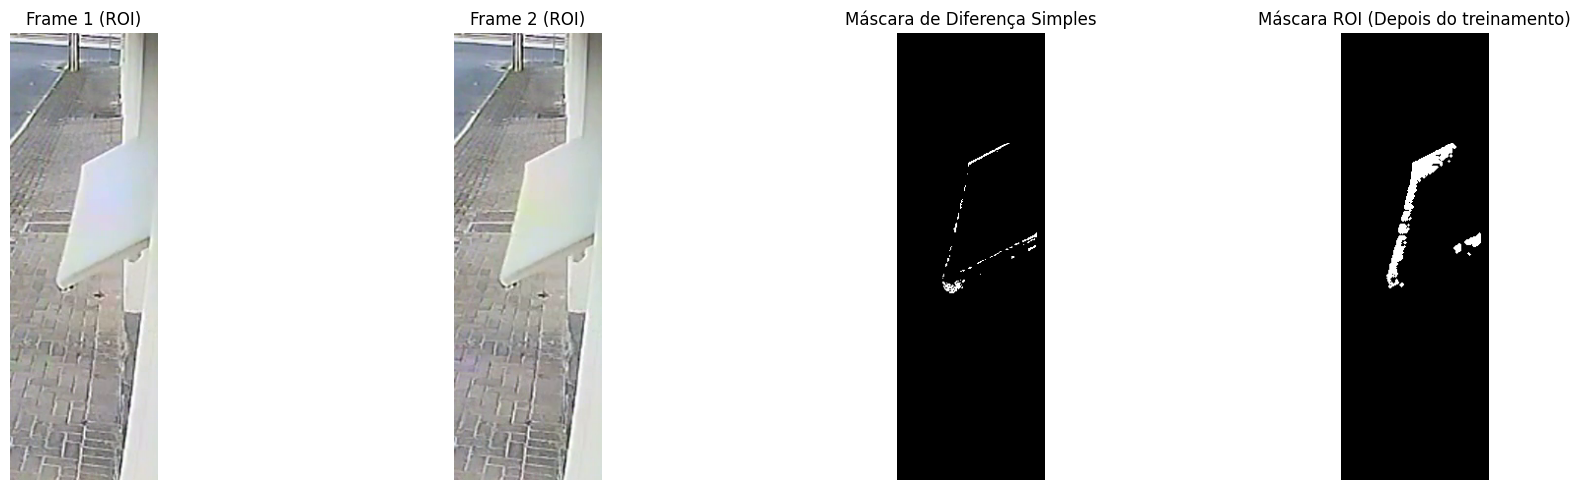

In [175]:
frame = video.set(cv.CAP_PROP_POS_FRAMES,87)
ret, frame = video.read()

video.set(cv.CAP_PROP_POS_FRAMES,88)  
ret2, frame2 = video.read()

if ret and ret2:
    roi1 = frame[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]
    roi2 = frame2[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]


    diff = cv.absdiff(roi1, roi2)
    diff_gray = cv.cvtColor(diff, cv.COLOR_BGR2GRAY)
    _, diff_mask = cv.threshold(diff_gray, 30, 255, cv.THRESH_BINARY)

    plt.figure(figsize=(20,5))
    plt.subplot(1,4,1)
    plt.imshow(cv.cvtColor(roi1, cv.COLOR_BGR2RGB))
    plt.title('Frame 1 (ROI)')
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow(cv.cvtColor(roi2, cv.COLOR_BGR2RGB))
    plt.title('Frame 2 (ROI)')
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.imshow(diff_mask, cmap='gray')
    plt.title('Máscara de Diferença Simples')
    plt.axis('off')

    # com a nossa função retorna_mascara
    mask = retorna_mascara(roi2, bg_subtractor)

    plt.subplot(1,4,4)
    plt.imshow(mask, cmap='gray')
    plt.title('Máscara ROI (Depois do treinamento)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Não foi possível ler os dois frames para comparação.")

reset_video_to_start(video)

Agora vêm a lógica da execução em si, que conta a quantidade de movimento vinda da mascara e de acordo com o valor de threshold que definimos para movimento, determina os estados do portão. 

Se o movimento passar a quantidade esperada, e o portão estiver fechado, é possível que ele está sendo aberto. 
- Para definir isso, é visto se, por uma quantidade "n" de frames seguintes (5, no nosso caso), o movimento do portão continua a mudar, assim, ele muda para o estado aberto. 

- Caso a quantidade de movimento diminua, e ele esteja aberto, isso significa que ele pode ter sido fechado, assim é feita a devida verificação. Para o caso de portão com movimento parado, é feito uma verificação ainda para determinar se o portão realmente foi fechado, ou apenas foi aberto e deixado aberto. Essa verificação é feita com a contagem da tragetória de frames que o portão ocupa enquanto está "abrindo". Se essa contagem for menor do que a média que o portão levaria para abrir e fechar, quer dizer que ele foi deixado aberto, logo o evento deve ser avisado.

Frame 62: Gate opened
Time 4.13s: Gate opened
Frame 409: Gate closed
Time 27.27s: Gate closed


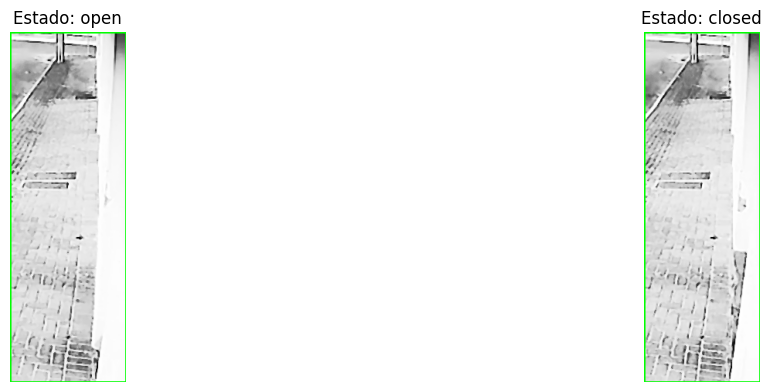

In [176]:
reset_video_to_start(video)
bg_subtractor = cv.createBackgroundSubtractorMOG2(history=100, varThreshold=50, detectShadows=False)
frame_count = 0

frames_interessantes = []

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break
        
    frame_count += 1
    current_time_seconds = frame_count / fps

    frame = retirar_ruidos_frame(frame)

    roi = frame[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]
    
    fgmask = retorna_mascara(roi, bg_subtractor)
    
    movement = cv.countNonZero(fgmask) # qtd de movimento
    
    cv.imshow("Foreground Mask", fgmask)
    
    if frame_count == "87":
        frames_interessantes.append({"roi": roi, "gate_state": gate_state})

    if gate_state == "open":
        qtd_frames_em_movimento += 1



    if movement > movement_threshold:
        
        if gate_state == "closed":
            opening_frames = 0
            for _ in range(stable_frames_threshold):
                ret, temp_frame = video.read()
                frame_count += 1
                current_time_seconds = frame_count / fps  # Converter frame para segundos
                if not ret:
                    break
                temp_roi = temp_frame[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]
                temp_fgmask = bg_subtractor.apply(temp_roi)
                if cv.countNonZero(temp_fgmask) > movement_threshold:
                    opening_frames += 1
            
            if opening_frames >= stable_frames_threshold:
                gate_state = "open"
                print(f"Frame {frame_count}: Gate opened")
                print(f"Time {current_time_seconds:.2f}s: Gate opened")  
                frames_interessantes.append({"roi": roi, "gate_state": gate_state})
    
    elif movement < movement_threshold//2:  
        if gate_state == "open":
            closing_frames = 0
            for _ in range(stable_frames_threshold):
                ret, temp_frame = video.read()
                frame_count += 1
                current_time_seconds = frame_count / fps  # Converter frame para segundos
                if not ret:
                    break
                temp_roi = temp_frame[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]
                temp_fgmask = bg_subtractor.apply(temp_roi)
                if cv.countNonZero(temp_fgmask) < movement_threshold//2:
                    closing_frames += 1
            
            if closing_frames >= stable_frames_threshold:
                if (qtd_frames_em_movimento < qtd_frames_para_abrir_fechar):
                    gate_state = "left_open"
                    print(f"Frame {frame_count}: Gate left open")
                    print(f"Time {current_time_seconds:.2f}s: Gate left open")
                    frames_interessantes.append({"roi": roi, "gate_state": gate_state})
                else:
                    gate_state = "closed"
                    qtd_frames_em_movimento = 0
                    print(f"Frame {frame_count}: Gate closed")
                    print(f"Time {current_time_seconds:.2f}s: Gate closed")
                    frames_interessantes.append({"roi": roi, "gate_state": gate_state})

    
    cv.putText(frame, f"State: {gate_state}", (20, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv.rectangle(frame, (roi_x, roi_y), (roi_x+roi_w, roi_y+roi_h), (0, 255, 0), 2)
    
    cv.imshow("Frame", frame)
    
    if cv.waitKey(30) == ord('q'):
        break

plt.figure(figsize=(15, 5 * 2))  
for i, frame in enumerate(frames_interessantes, 1):
    plt.subplot(2, len(frames_interessantes), i)
    plt.imshow(cv.cvtColor(frame['roi'], cv.COLOR_BGR2RGB))
    plt.title(f'Estado: {frame["gate_state"]}')
    plt.axis('off')
plt.show()


In [177]:
video.release()
cv.destroyAllWindows()

### Referências
<a id="referencias"></a>
1. [Improved Adaptive Gaussian Mixture Model for Background Subtraction]("./artigos/zivkovic2004ICPR.pdf")
